# GRASP, Greedy y Búsqueda Local

Muchos problemas de optimización combinatoria son NP-completos, como se vió la clase pasada. Existen diversas estrategias para poder aproximarnos al óptimo global, muchas de ellas consistiendo en movimiento locales a partir de un punto inicial.

Dado nuestro poliedro de soluciones factibles, nos estaremos movimiendo en alguna dirección, bajo cierto conjunto de reglas, **sin tener visión del escenario global**. De ahí subyace en nombre de búsqueda local.

## Greedy vs GRASP en el *Travelling Salesman Problem*

Retomando el ejemplo de la clase pasada, asumamos que somos un emprendedor que debe distribuir su productos a cafeterías. En esta instancia, nos centraremos en la comuna de Santiago

In [21]:
import osmnx as ox
import numpy as np
import geopandas as gpd


def obtenerGrafo(cantidadNodos, seed=42, noise_level=0.7):
    """
    Obtiene un grafo representando las cafeterías disponibles en Buenos Aires.

    Parámetros
    ----------
    cantidadNodos: int
        Cantidad de nodos a tener. Si sobrepasa la cantidad total de cafeterías, devuelve el mínimo.


    seed: int
        Semilla para determinar el ruido entre aristas

    noise_level: float
        Ruido que se añade a cada arista, para simular tráfico.

    Retorna
    -------

    nx.Graph: grafo con metadata para poder graficar y nodos correspondientes a cada cafetería.
    """
    # -----
    # Leer grafo de Buenos Aires
    # -----
    rng = np.random.default_rng(seed)
    ciudad = "santiago"
    G = ox.load_graphml(f"data/{ciudad}_drive.graphml")
    pois = gpd.read_file(f"data/cafes_{ciudad}.geojson")
    pois = pois[pois.geometry.type == "Point"].reset_index(drop=True)

    # -----
    # Obtener puntos de interés y muestrear
    # -----
    pois = pois.sample(min(cantidadNodos, len(pois)), random_state=seed).reset_index(
        drop=True
    )
    lats = pois.geometry.y.values
    lons = pois.geometry.x.values
    poi_nodes = ox.nearest_nodes(G, lons, lats)
    N = len(pois)

    # -----
    # Construir grafo completo optimizado
    # -----
    def dists_from(src):
        try:
            return nx.single_source_dijkstra_path_length(
                G, source=src, weight="travel_time"
            )
        except Exception:
            return nx.single_source_dijkstra_path_length(G, source=src, weight="length")

    K = nx.complete_graph(N)
    for i in range(N):
        dist_i = dists_from(poi_nodes[i])
        for j in range(i + 1, N):
            base_w = float(dist_i[poi_nodes[j]])
            noisy_w = base_w * rng.uniform(1.0 - noise_level, 1.0 + noise_level)
            K.add_edge(i, j, weight=noisy_w)

    # -----
    # Guardar metadatos para graficar después
    # -----
    K.graph["poi_nodes"] = poi_nodes
    K.graph["city"] = ciudad
    K.graph["pos"] = {
        i: (G.nodes[poi_nodes[i]]["x"], G.nodes[poi_nodes[i]]["y"]) for i in range(N)
    }

    return K


def graficar(K, labels=False, edge_alpha=0.25):
    """
    Grafica el grafo obtenido con 'obtenerGrafo'.

    Parámetros
    ----------
    K: networkx.MultiDiGraph (o Graph)
        Grafo a graficar

    labels: bool
        Lógico que determina si añadimos etiquetas a las aristas

    edge_alpha: float
        Opacidad de las aristas
    """

    # -----
    # Cargar grafo
    # -----
    path = "data/santiago_drive.graphml"
    Gbg = ox.load_graphml(path)

    # -----
    # Leer metadata de gráfico
    # -----
    pos = K.graph["pos"]

    # -----
    # Definir estilos
    # -----
    pesos = [d["weight"] for _, _, d in K.edges(data=True)]
    wmin, wmax = min(pesos), max(pesos)
    eps = 1e-9
    ancho_aristas = [1.0 + 3.0 * (wmax - w) / (wmax - wmin + eps) for w in pesos]
    labels_aristas = {(i, j): f"{K[i][j]['weight']/60:.1f} min" for i, j in K.edges()}

    # -----
    # Dibujar fondo de Buenos Aires
    # -----
    fig, ax = ox.plot_graph(
        Gbg,
        node_size=0,
        edge_color="#d9d9d9",
        edge_linewidth=0.6,
        bgcolor="white",
        show=False,
        close=False,
    )

    # -----
    # Dibujar el grafo
    # -----
    nx.draw_networkx_edges(
        K, pos, ax=ax, width=ancho_aristas, edge_color="tab:blue", alpha=edge_alpha
    )
    nx.draw_networkx_nodes(
        K,
        pos,
        ax=ax,
        node_size=40,
        node_color="crimson",
        edgecolors="white",
        linewidths=0.8,
    )
    nx.draw_networkx_labels(K, pos, ax=ax, font_size=8)

    if labels:
        nx.draw_networkx_edge_labels(
            K, pos, ax=ax, edge_labels=labels_aristas, font_size=7, rotate=False
        )

    plt.tight_layout()
    plt.show()

In [47]:
G = obtenerGrafo(200, noise_level=0.9)

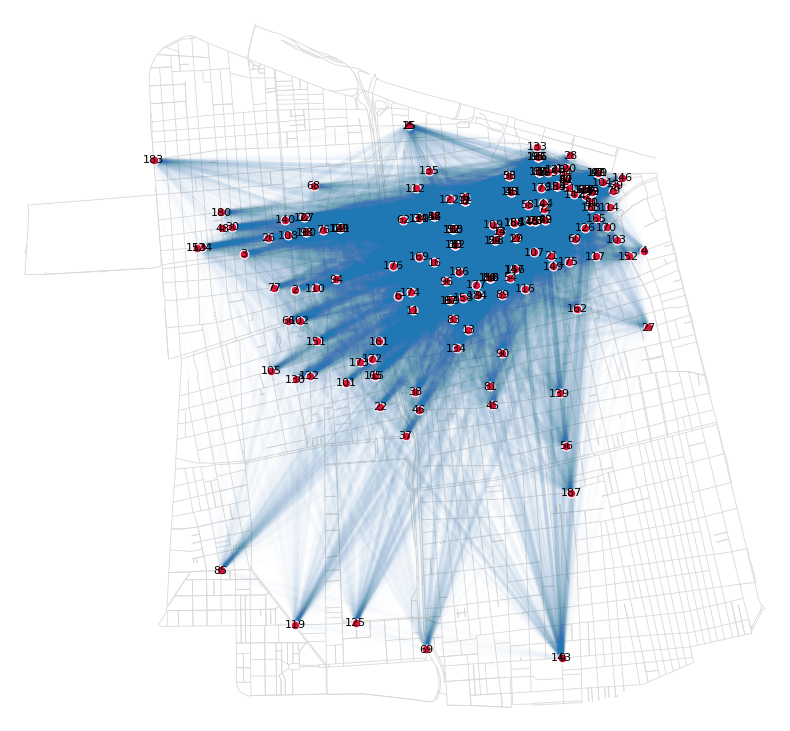

In [28]:
graficar(G, labels=False, edge_alpha=0.01)

Para este ejercicio, nos centraremos en determinar qué tanto diverge la solución greedy con GRASP para el TSP. En específico, nos fijaremos en los precios y rutas.

Para lograr aquello, será necesario programar el algoritmo greedy y GRASP.

In [51]:
import random


def costo_greedy(G):
    """
    Devuelve el costo total del tour TSP construido con la heurística greedy
    sobre el grafo G. No devuelve el tour, solo el costo.

    Parámetros
    ----------

    G : nx.Graph
        Grafo completo no dirigido con 'weight' en cada arista.
    """
    weight = "weight"
    nodos = list(G)
    s = nodos[0]
    no_visitados = set(nodos)
    no_visitados.remove(s)
    u, total = s, 0.0

    while no_visitados:
        v = min(no_visitados, key=lambda x: G[u][x][weight])
        total += G[u][v][weight]
        u = v
        no_visitados.remove(v)

    return float(total + G[u][s][weight])


def costo_grasp(G, iters=50, rcl_size=3, seed=0):
    """
    Devuelve el mejor costo encontrado por GRASP SIN 2-opt (solo construcción aleatorizada).

    Parámetros
    ----------

    iters: int
        número de intentos

    rcl_size: int
        tamaño de la lista restringida de candidatos (RCL)

    seed: int
        semilla

    Retorna
    -------

    int: El costo total del tour
    """

    weight = "weight"
    rnd = random.Random(seed)
    nodos = list(G)
    mejor = float("inf")

    # -----
    # Ejecutamos la cantidad total de intentos
    # -----
    for _ in range(iters):
        # Elegimos un nodo al azar para iniciar
        s = rnd.choice(nodos)
        # Nos definimos un conjunto de nodos no iniciados
        # y descontamos aquel que elegimos para iniciar
        no_visit = set(nodos)
        no_visit.remove(s)
        u, total = s, 0.0
        # Mientras el conjunto sigue lleno
        while no_visit:
            # Ordenamos las aristas en base al costo de los vecinos
            cand = sorted(no_visit, key=lambda v: G[u][v][weight])
            # Obtenemos la lista RCL, donde nos quedamos con los mejores
            rcl = cand[: max(1, min(rcl_size, len(cand)))]
            # Elegimos al azar dentro de la lista
            v = rnd.choice(rcl)
            # Lo añadimos al total y partimos desde el nodo nuevo.
            total += G[u][v][weight]
            u = v
            no_visit.remove(v)
        total += G[u][s][weight]  # cerrar ciclo
        if total < mejor:
            mejor = total

    return mejor

Como pueden ver, el algoritmo greedy **tuvo un mejor** costo que el GRASP. 

Para introducir, realmente, la aleatoridad, se construye el método `2-opt`. Al terminar el tour, se recorre y eligue las aristas subyacentes. Se evalua si vale la pena hacer un swap entre ambas aristas, tal que el costo total disminuye. De ser así, se hace el swap: 

$$\Delta = (w(a,c) + w(b,d)) - (w(a,b) - w(c,d))$$

Si $\Delta < 0$, el swap reduciría el costo.

Un ejemplo breve es con el siguiente tour $[0,1,2,3,4,5,0]$. Si elegimos las aristas $(1,2)$ y $(3,4)$, el swap invertiría el tramo tal que el tramo se convertiría de: 

- Original: $1 - 2 - 3 - 4 - 5$
- Con swap: $1 - 4 - 3 - 2 - 5$

Así, al GRASP habría que añadir un loop que haga el recorrido del tour:

In [54]:
def costo_grasp(G, iters=50, rcl_size=3, weight="weight", seed=0):
    """
    Devuelve el mejor costo encontrado por GRASP CON 2-opt.

    Parámetros
    ----------

    iters: int
        número de intentos

    rcl_size: int
        tamaño de la lista restringida de candidatos (RCL)

    seed: int
        semilla

    Retorna
    -------

    int: El costo total del tour
    """

    rng = random.Random(seed)
    N = list(G)

    def costo(tour):
        """
        Retorna el costo total del tour
        """
        return float(sum(G[u][v][weight] for u, v in zip(tour, tour[1:])))

    mejor = float("inf")

    # -----
    # Iteramos por la cantidad total de intentos
    # -----
    for _ in range(iters):
        # Construcción greedy aleatorizada (RCL)
        # -----
        # Introducimos la misma solución del GRASP original
        # -----
        s = rng.choice(N)
        no_visitados = set(N)
        no_visitados.remove(s)
        u, tour = s, [s]
        while no_visitados:
            cand = sorted(no_visitados, key=lambda v: G[u][v][weight])
            rcl = cand[: max(1, min(rcl_size, len(cand)))]
            v = rng.choice(rcl)
            tour.append(v)
            no_visitados.remove(v)
            u = v
        tour.append(s)

        # Búsqueda local 2-opt
        # -----
        # Se hace recorre el tour completo
        # -----
        improved = True
        while improved:
            improved = False
            n = len(tour) - 1
            # Por cada nodo que hay
            for i in range(1, n - 1):
                # Por cada nodo siguiente
                for k in range(i + 1, n):
                    # Elegimos la primera arista
                    a, b = tour[i - 1], tour[i]
                    # Elegimos la segunda arista
                    c, d = tour[k], tour[k + 1]
                    # Si el costo mejora
                    if (
                        G[a][c][weight] + G[b][d][weight]
                        < G[a][b][weight] + G[c][d][weight] - 1e-12
                    ):
                        tour[i : k + 1] = reversed(tour[i : k + 1])
                        improved = True
                        break
                # Si el costo mejora, volvemos a intentar recorriendo todo el tour con el nuevo cambio
                if improved:
                    break

        mejor = min(mejor, costo(tour))
    return mejor

In [55]:
print(costo_greedy(G))
print(costo_grasp(G, iters=50, rcl_size=4))

2510.064266266096
1903.1236842219657


Como pueden ver, GRASP mejora la solución greedy pero por un costo en el rendimiento. Sin embargo, la ganancia es significativa al saber que el costo greedy implica un tour de 41 minutos mientras que el GRASP uno de 31. 

## ¿Cuándo no vale la pena ocupar GRASP? 

Hay dos características principales que haría que la conveniencia de GRASP disminuya en TSP: 

- Datos altamente métricos: al trabajar con redes viales, se suele cumplir que el enfoque greedy suele ganar al enfoque GRASP ya que la mayoría de las aristas cumplen con la desigualdad triangular. Esto se ajusta con el parámetro `noise_level` de `obtenerGrafo`.
- En instancias chicas el enfoque greedy suele ser muy bueno, incluso llegando a un óptimo en ciertos casos.

A continuación, veamos como evoluciona el gap entre la solución GRASP y greedy en función del tamaño de la instancia. En específico, impondremos 

$$\text{GAP} = \frac{(\text{Costo}_{\text{GRASP}}-\text{Costo}_{\text{Greedy}})}{\text{Costo}_\text{Greedy}}\cdot 100$$

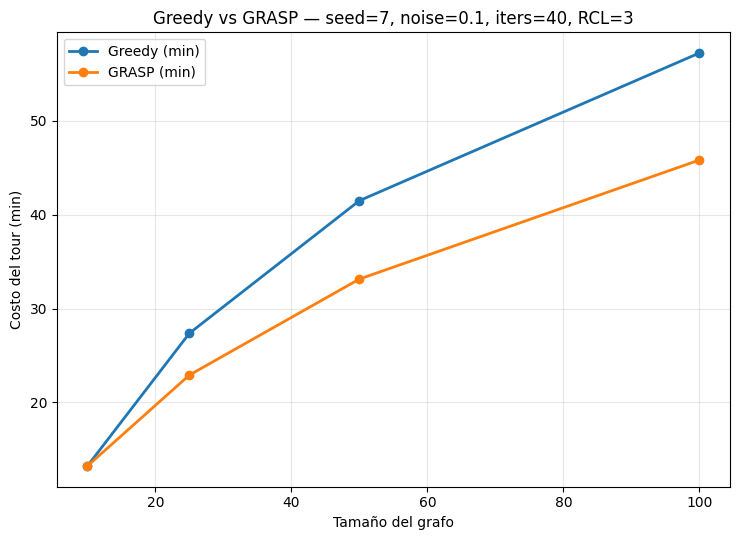

In [58]:
import matplotlib.pyplot as plt

# -----
# Parámetros
# -----
SIZES = [10, 25, 50, 100]
SEED = 7
NOISE = 0.1
ITERS = 40  # iteraciones de GRASP
RCLSIZE = 3  # tamaño de la RCL

cost_greedy_min = []
cost_grasp_min = []
gap_pct = []

for n in SIZES:
    K = obtenerGrafo(n, seed=SEED, noise_level=NOISE)
    c_greedy = costo_greedy(K)  # segundos
    c_grasp = costo_grasp(K, iters=ITERS, rcl_size=RCLSIZE, seed=SEED)  # segundos

    # -----
    # Convertir los costos a minutos
    # -----
    cost_greedy_min.append(c_greedy / 60.0)
    cost_grasp_min.append(c_grasp / 60.0)
    gap_pct.append((c_grasp - c_greedy) / c_greedy * 100.0)

fig, ax = plt.subplots(figsize=(7.5, 5.5))

# Costos en minutos
ax.plot(SIZES, cost_greedy_min, marker="o", linewidth=2, label="Greedy (min)")
ax.plot(SIZES, cost_grasp_min, marker="o", linewidth=2, label="GRASP (min)")
ax.set_xlabel("Tamaño del grafo")
ax.set_ylabel("Costo del tour (min)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left")

plt.title(f"Greedy vs GRASP — seed={SEED}, noise={NOISE}, iters={ITERS}, RCL={RCLSIZE}")
plt.tight_layout()
plt.show()

De todas formas, se puede apreciar que GRASP casi siempre llega a ser una buena opción en este tipo de problemas.